In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10 #Load the CIFAR10 dataset
from torch.utils.data import DataLoader #For creating dataloader
import torchvision.transforms as transforms #For data transformations

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
#Task 1: Data Preparation: Modify the CIFAR-10 dataset by introducing symmetric noise rate η ∈[0.2, 0.8] by randomly flipping the labels within each class to incorrect labels from other classes.

def add_symmetric_noise(dataset, noise_rate):
  #returns dataset with noisy labels.
  targets =  np.array(dataset.targets) # We are converting the labels into an array
  num_classes = len(set(targets)) # We are getting the number of classes and here set ensures they are unique
  noisy_targets = targets.copy() #Make a copy of labels to modify it.

  for i in range(len(targets)):
    if np.random.rand() < noise_rate:
      noisy_targets[i] = np.random.choice(
          [j for j in range(num_classes) if j != targets[i]]
      )

  dataset.targets = noisy_targets.tolist() #Converts to python list
  return dataset

# Define data transformations to prepare the images for training
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Load the CIFAR-10 dataset
cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Introduce symmetric noise with a noise rate of 40%
noisy_cifar10 = add_symmetric_noise(cifar10, noise_rate=0.4)

# Create a DataLoader to efficiently load and batch the data during training
data_loader = DataLoader(noisy_cifar10, batch_size=64, shuffle=True)

# Explanation:
# 1. `CIFAR10`: Downloads and loads the CIFAR-10 dataset.
# 2. `add_symmetric_noise`: Introduces random label flipping for symmetric noise.
# 3. `DataLoader`: Splits the dataset into batches of 64 for training.

100%|██████████| 170M/170M [00:02<00:00, 58.8MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified

--- Training models with Noise Level: 0.2 ---

Training Cross-Entropy model...
Epoch 1/10, Loss: 1394.6191, Accuracy: 0.4152
Epoch 2/10, Loss: 1218.0845, Accuracy: 0.5274
Epoch 3/10, Loss: 1135.2099, Accuracy: 0.5690
Epoch 4/10, Loss: 1060.4236, Accuracy: 0.6039
Epoch 5/10, Loss: 977.9613, Accuracy: 0.6342
Epoch 6/10, Loss: 887.3216, Accuracy: 0.6660
Epoch 7/10, Loss: 790.9387, Accuracy: 0.6955
Epoch 8/10, Loss: 688.4663, Accuracy: 0.7319
Epoch 9/10, Loss: 581.8924, Accuracy: 0.7687
Epoch 10/10, Loss: 486.9643, Accuracy: 0.8043

Training Focal Loss model...
Epoch 1/10, Loss: 1035.1018, Accuracy: 0.4078
Epoch 2/10, Loss: 881.6037, Accuracy: 0.5164
Epoch 3/10, Loss: 813.5099, Accuracy: 0.5610
Epoch 4/10, Loss: 759.7625, Accuracy: 0.5883
Epoch 5/10, Loss: 701.9723, Accuracy: 0.6138
Epoch 6/10, Loss: 642.9498, Accuracy: 0.6379
Epoch 7/10, Loss: 579.5009, Accuracy: 0.6606
Epoch 8/10, Loss: 510.8290, Accuracy: 0.6853
Epoch 9/10, Loss: 444.6741, Accuracy

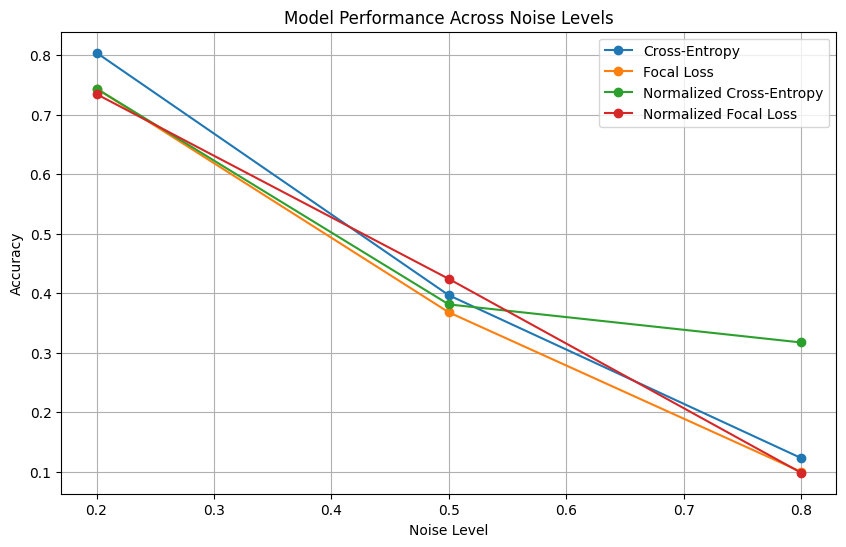

In [4]:
# Task 2: Normalized Losses - Full Updated Code

# Importing Required Libraries
import torch  # PyTorch for tensor operations
import torch.nn.functional as F  # For activation functions and loss computations
import matplotlib.pyplot as plt  # For plotting results
import numpy as np  # For numerical operations
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms



# Function: Normalized Cross-Entropy Loss
def normalized_cross_entropy(logits, targets):
    """
    Compute Normalized Cross-Entropy (NCE) Loss.
    Args:
        logits: The raw predictions from the model (before applying softmax).
        targets: The true labels (indices).
    Returns:
        NCE loss value (averaged over the batch).
    """
    probs = F.softmax(logits, dim=1)
    nce_loss = -torch.log(probs[range(targets.size(0)), targets])
    return nce_loss.mean()

# Function: Normalized Focal Loss
def normalized_focal_loss(logits, targets, gamma=2.0):
    """
    Compute Normalized Focal Loss (NFL).
    Args:
        logits: The raw predictions from the model.
        targets: The true labels (indices).
        gamma: Focusing parameter to reduce the impact of easy-to-classify examples.
    Returns:
        NFL loss value (averaged over the batch).
    """
    probs = F.softmax(logits, dim=1)
    focal_loss = -((1 - probs[range(targets.size(0)), targets]) ** gamma) * torch.log(probs[range(targets.size(0)), targets])
    return focal_loss.mean()

# Function: Cross-Entropy Loss
def cross_entropy_loss(logits, targets):
    """
    Compute the standard Cross-Entropy Loss.
    Args:
        logits: Raw predictions from the model.
        targets: True class labels.
    Returns:
        Cross-Entropy loss value.
    """
    return F.cross_entropy(logits, targets)

# Function: Standard Focal Loss
def focal_loss(logits, targets, gamma=2.0):
    """
    Compute the standard Focal Loss.
    Args:
        logits: Raw predictions from the model.
        targets: True class labels.
        gamma: Focusing parameter to reduce the impact of easy-to-classify examples.
    Returns:
        Focal loss value (averaged over the batch).
    """
    probs = F.softmax(logits, dim=1)
    focal_loss = -((1 - probs[range(targets.size(0)), targets]) ** gamma) * torch.log(probs[range(targets.size(0)), targets])
    return focal_loss.mean()

# Class: Simple Convolutional Neural Network (CNN)
#####HAVE TO START FROM HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function: Training the Model
def train_model(model, data_loader, loss_fn, optimizer, num_epochs=10, device='cuda', label=None):
    model = model.to(device)
    epoch_accuracies = []

    print(f"\nTraining {label} model...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()

        accuracy = correct / len(data_loader.dataset)
        epoch_accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    return epoch_accuracies

# Function: Plotting Results
def plot_performance(noise_levels, ce_results, focal_results, nce_results, nfl_results):
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, ce_results, label='Cross-Entropy', marker='o')
    plt.plot(noise_levels, focal_results, label='Focal Loss', marker='o')
    plt.plot(noise_levels, nce_results, label='Normalized Cross-Entropy', marker='o')
    plt.plot(noise_levels, nfl_results, label='Normalized Focal Loss', marker='o')

    plt.title("Model Performance Across Noise Levels")
    plt.xlabel("Noise Level")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Training and Comparing Models Across Noise Levels
noise_levels = [0.2, 0.5, 0.8]
ce_accuracies = []
focal_accuracies = []
nce_accuracies = []
nfl_accuracies = []

for noise_rate in noise_levels:
    print(f"\n--- Training models with Noise Level: {noise_rate} ---")
    noisy_cifar10 = add_symmetric_noise(cifar10, noise_rate)
    noisy_data_loader = DataLoader(noisy_cifar10, batch_size=64, shuffle=True)

    # Cross-Entropy Loss
    ce_model = SimpleCNN()
    ce_optimizer = torch.optim.Adam(ce_model.parameters(), lr=0.001)
    ce_acc = train_model(ce_model, noisy_data_loader, cross_entropy_loss, ce_optimizer, num_epochs=10, label="Cross-Entropy")
    ce_accuracies.append(ce_acc[-1])

    # Focal Loss
    focal_model = SimpleCNN()
    focal_optimizer = torch.optim.Adam(focal_model.parameters(), lr=0.001)
    focal_acc = train_model(focal_model, noisy_data_loader, lambda logits, targets: focal_loss(logits, targets, gamma=2.0), focal_optimizer, num_epochs=10, label="Focal Loss")
    focal_accuracies.append(focal_acc[-1])

    # Normalized Cross-Entropy Loss
    nce_model = SimpleCNN()
    nce_optimizer = torch.optim.Adam(nce_model.parameters(), lr=0.001)
    nce_acc = train_model(nce_model, noisy_data_loader, normalized_cross_entropy, nce_optimizer, num_epochs=10, label="Normalized Cross-Entropy")
    nce_accuracies.append(nce_acc[-1])

    # Normalized Focal Loss
    nfl_model = SimpleCNN()
    nfl_optimizer = torch.optim.Adam(nfl_model.parameters(), lr=0.001)
    nfl_acc = train_model(nfl_model, noisy_data_loader, lambda logits, targets: normalized_focal_loss(logits, targets, gamma=2.0), nfl_optimizer, num_epochs=10, label="Normalized Focal Loss")
    nfl_accuracies.append(nfl_acc[-1])

# Plot the performance trends
plot_performance(noise_levels, ce_accuracies, focal_accuracies, nce_accuracies, nfl_accuracies)


Files already downloaded and verified

--- Training APL model with Noise Level: 0.2 ---
Epoch 1/20, Loss: 1218.1543, Accuracy: 0.4022
Epoch 2/20, Loss: 965.4456, Accuracy: 0.5150
Epoch 3/20, Loss: 851.8501, Accuracy: 0.5588
Epoch 4/20, Loss: 752.7213, Accuracy: 0.5934
Epoch 5/20, Loss: 653.8809, Accuracy: 0.6231
Epoch 6/20, Loss: 546.5126, Accuracy: 0.6517
Epoch 7/20, Loss: 435.7316, Accuracy: 0.6814
Epoch 8/20, Loss: 310.5001, Accuracy: 0.7130
Epoch 9/20, Loss: 182.6575, Accuracy: 0.7450
Epoch 10/20, Loss: 54.8364, Accuracy: 0.7796
Epoch 11/20, Loss: -69.4921, Accuracy: 0.8118
Epoch 12/20, Loss: -182.9663, Accuracy: 0.8429
Epoch 13/20, Loss: -284.5917, Accuracy: 0.8682
Epoch 14/20, Loss: -366.7909, Accuracy: 0.8895
Epoch 15/20, Loss: -446.5641, Accuracy: 0.9105
Epoch 16/20, Loss: -511.0472, Accuracy: 0.9285
Epoch 17/20, Loss: -544.7298, Accuracy: 0.9352
Epoch 18/20, Loss: -583.6073, Accuracy: 0.9463
Epoch 19/20, Loss: -604.3055, Accuracy: 0.9504
Epoch 20/20, Loss: -625.7619, Accuracy:

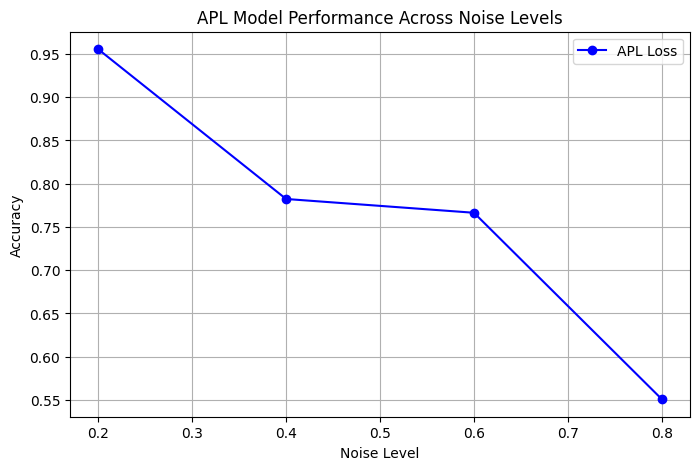

In [5]:
# Function: Active-Passive Loss (APL)
def apl_loss(logits, targets, alpha=1.0, beta=1.0, gamma=2.0):
    """
    Compute Active-Passive Loss (APL).
    Combines an active loss (e.g., NCE or Focal) with a passive loss (e.g., MAE or RCE).
    Args:
        logits: Raw predictions from the model.
        targets: True class labels.
        alpha: Weight for active loss.
        beta: Weight for passive loss.
        gamma: Focusing parameter for Focal Loss.
    Returns:
        APL loss value (averaged over the batch).
    """
    probs = F.softmax(logits, dim=1)
    # Active loss: Normalized Cross-Entropy (NCE)
    nce_loss = -torch.log(probs[range(targets.size(0)), targets])
    # Passive loss: Reverse Cross-Entropy (RCE)
    rce_loss = -torch.sum(probs * F.one_hot(targets, num_classes=logits.size(1)).to(logits.device), dim=1)
    # Combine losses
    return alpha * nce_loss.mean() + beta * rce_loss.mean()

# Class: Simple Convolutional Neural Network (CNN)
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function: Training the Model
def train_apl_model(model, data_loader, optimizer, num_epochs=20, device='cuda', alpha=1.0, beta=1.0, gamma=2.0):
    """
    Train a model using the APL loss function.
    Args:
        model: Neural network to be trained.
        data_loader: DataLoader providing training data.
        optimizer: Optimizer to update model weights.
        num_epochs: Number of epochs to train.
        device: Device to use ('cuda' or 'cpu').
        alpha: Weight for active loss.
        beta: Weight for passive loss.
        gamma: Focusing parameter for focal-like loss.
    Returns:
        List of accuracies for each epoch.
    """
    model = model.to(device)
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = apl_loss(logits, labels, alpha=alpha, beta=beta, gamma=gamma)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()

        accuracy = correct / len(data_loader.dataset)
        epoch_accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    return epoch_accuracies

# Function: Plotting Results
def plot_apl_performance(noise_levels, apl_accuracies):
    """
    Plot accuracy trends for APL across different noise levels.
    Args:
        noise_levels: List of noise levels.
        apl_accuracies: List of accuracies for APL Loss.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(noise_levels, apl_accuracies, label='APL Loss', marker='o', color='blue')
    plt.title("APL Model Performance Across Noise Levels")
    plt.xlabel("Noise Level")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Training APL Model Across Noise Levels
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)

noise_levels = [0.2, 0.4, 0.6, 0.8]
apl_accuracies = []

for noise_rate in noise_levels:
    print(f"\n--- Training APL model with Noise Level: {noise_rate} ---")
    noisy_cifar10 = add_symmetric_noise(cifar10, noise_rate)
    noisy_data_loader = DataLoader(noisy_cifar10, batch_size=64, shuffle=True)

    # Initialize model and optimizer
    apl_model = SimpleCNN()
    apl_optimizer = torch.optim.Adam(apl_model.parameters(), lr=0.001)

    # Train the model using APL loss
    apl_acc = train_apl_model(apl_model, noisy_data_loader, apl_optimizer, num_epochs=20, alpha=1.0, beta=1.0, gamma=2.0)
    apl_accuracies.append(apl_acc[-1])  # Append the final accuracy

# Plot the APL performance
plot_apl_performance(noise_levels, apl_accuracies)